# Quantum Fourier Transform Benchmark

In [1]:
low = 1
high = 28
samples = 100

In [2]:
import time
import random
import math
import numpy as np

## FFTW ("Classical" DFT)

In [3]:
# See https://blog.hpc.qmul.ac.uk/pyfftw.html
import pyfftw

pyfftw.interfaces.cache.enable()
pyfftw.interfaces.cache.set_keepalive_time(60)
total_time = 0

fftw_results = {}
for n in range(low, high + 1):
    width_results = []
    for i in range(samples):
        io_array = pyfftw.empty_aligned(2**n, dtype=np.complex64)
        io_array[0] = 1.
        start = time.perf_counter()
        pyfftw.interfaces.numpy_fft.fft(io_array, overwrite_input=True, threads = (16 if (n > 18) else 1))
        width_results.append(time.perf_counter() - start)

    fftw_results[n] = sum(width_results) / samples

print(fftw_results)

{1: 2.3006089995760704e-05, 2: 2.0822799983761796e-05, 3: 2.054769002370449e-05, 4: 2.0099780031159752e-05, 5: 2.1440280011120195e-05, 6: 2.1273230013321155e-05, 7: 2.190560999679292e-05, 8: 2.2048169998925005e-05, 9: 2.3568309979964398e-05, 10: 2.6046570037578932e-05, 11: 3.139048000775802e-05, 12: 0.00011211543997433182, 13: 6.794784000703658e-05, 14: 9.254447999865078e-05, 15: 0.00016269649000150822, 16: 0.00033406894000563624, 17: 0.0007405886199921952, 18: 0.0017311827400135372, 19: 0.0023198930000035032, 20: 0.004133004840000467, 21: 0.00794700869999815, 22: 0.025141230190024545, 23: 0.05272323301999677, 24: 0.11642324648002159, 25: 0.21072122468998714, 26: 0.39961260502001095, 27: 0.8252077446800149, 28: 2.051407098779996}


## PyQrack

In [4]:
%env QRACK_QUNITMULTI_DEVICES 1
from pyqrack import QrackSimulator, Pauli

def reverse_qrack(sim):
    start = 0
    end = sim.num_qubits() - 1
    while (start < end):
        sim.swap(start, end)
        start += 1
        end -= 1

env: QRACK_QUNITMULTI_DEVICES=1


### |0> initialization

In [5]:
def bench_qrack_0(n):
    sim = QrackSimulator(n)
    # Permutation basis eigenstate initialization before QFT is "trivial" for Qrack.
    start = time.perf_counter()
    qubits = [i for i in range(n)]
    sim.qft(qubits)
    reverse_qrack(sim)
    sim.m_all()

    return time.perf_counter() - start

qrack_0_results = {}
for n in range(low, high + 1):
    width_results = []
        
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_qrack_0(n))

    qrack_0_results[n] = sum(width_results) / samples

print(qrack_0_results)

Device #0, Loaded binary from: /home/iamu/.qrack/qrack_ocl_dev_Intel(R)_UHD_Graphics_[0x9bc4].ir
Device #1, Loaded binary from: /home/iamu/.qrack/qrack_ocl_dev_NVIDIA_GeForce_RTX_3080_Laptop_GPU.ir
{1: 6.589100003111526e-06, 2: 8.627690026514757e-06, 3: 9.981460016206256e-06, 4: 1.1975990018981974e-05, 5: 1.983525998184632e-05, 6: 1.6435399984402466e-05, 7: 1.867383997705474e-05, 8: 2.1451290003824396e-05, 9: 2.3808099990674235e-05, 10: 2.6298139982827706e-05, 11: 2.8685559964287677e-05, 12: 3.143108002859663e-05, 13: 3.383594997558248e-05, 14: 3.742388000318897e-05, 15: 4.0002139999160133e-05, 16: 4.35932699838304e-05, 17: 4.643561001557828e-05, 18: 5.02076400198348e-05, 19: 5.300234998230735e-05, 20: 5.736502001127519e-05, 21: 6.282621001901133e-05, 22: 6.991916001425124e-05, 23: 6.734038004196918e-05, 24: 7.163580000451474e-05, 25: 7.618997002282412e-05, 26: 7.975619000717415e-05, 27: 8.350572003564594e-05, 28: 8.781857002759352e-05}


### Random 1-qubit unitary initialization

In [6]:
def bench_qrack(n):
    sim = QrackSimulator(n)
    # Permutation basis eigenstate initialization before QFT is "trivial" for Qrack,
    # so we give it a realistic case instead.
    for i in range(n):
        # Initialize with uniformly random single qubit gates, across full width.
        sim.u(i, random.uniform(0, 4 * math.pi), random.uniform(0, 4 * math.pi), random.uniform(0, 4 * math.pi))
    start = time.perf_counter()
    qubits = [i for i in range(n)]
    sim.qft(qubits)
    reverse_qrack(sim)
    sim.m_all()

    return time.perf_counter() - start

qrack_results = {}
for n in range(low, high + 1):
    width_results = []
        
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_qrack(n))

    qrack_results[n] = sum(width_results) / samples

print(qrack_results)

{1: 7.79198000600445e-06, 2: 5.063489000804111e-05, 3: 0.0001463630699799978, 4: 0.00020556441999815432, 5: 0.0002364087399928394, 6: 0.00030343854999046013, 7: 0.0003856357899849172, 8: 0.0004756898300138346, 9: 0.0006175303500049268, 10: 0.0008551514299688279, 11: 0.0014637343899767076, 12: 0.0019068532999517629, 13: 0.0022941579800044563, 14: 0.002712080609981058, 15: 0.003120762050029953, 16: 0.003562425519990029, 17: 0.003910643449962663, 18: 0.004470290559984278, 19: 0.0053467566499830355, 20: 0.007421945950018199, 21: 0.01041487227001653, 22: 0.015922982070028412, 23: 0.026941218599963578, 24: 0.04813724144999924, 25: 0.090515423679999, 26: 0.1759803606500009, 27: 0.3483917714000108, 28: 0.6884059217299864}


## Qiskit Aer

In [7]:
from qiskit import QuantumCircuit
from qiskit import execute, Aer
from qiskit.providers.aer import QasmSimulator

def reverse_aer(num_qubits, circ):
    start = 0
    end = num_qubits - 1
    while (start < end):
        circ.swap(start, end)
        start += 1
        end -= 1

# Implementation of the Quantum Fourier Transform
def aer_qft(num_qubits, circ):
    # Quantum Fourier Transform
    for j in range(num_qubits):
        for k in range(j):
            circ.cp(math.pi/float(2**(j-k)), j, k)
        circ.h(j)
    reverse_aer(num_qubits, circ)
    for j in range(num_qubits):
        circ.measure(j, j)

    return circ

sim_backend = QasmSimulator(shots=1, method='statevector_gpu')

def bench_aer(num_qubits):
    circ = QuantumCircuit(num_qubits, num_qubits)
    aer_qft(num_qubits, circ)
    start = time.perf_counter()
    job = execute([circ], sim_backend, timeout=600)
    result = job.result()
    return time.perf_counter() - start

aer_results = {}
for n in range(low, high + 1):
    width_results = []
        
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_aer(n))

    aer_results[n] = sum(width_results) / samples

print(aer_results)

{1: 0.003413271770018582, 2: 0.0034116494799900465, 3: 0.003973048279999602, 4: 0.004684085599997161, 5: 0.0053984749399933205, 6: 0.006149162649999198, 7: 0.006910795089970634, 8: 0.007932468219978546, 9: 0.00866605785000047, 10: 0.009551283660025547, 11: 0.010716149210006734, 12: 0.011663890839959095, 13: 0.01307105097997919, 14: 0.013846095980002247, 15: 0.015618187620011667, 16: 0.016870199810005034, 17: 0.01858192383999267, 18: 0.02039223930996741, 19: 0.024010961600019982, 20: 0.030353578800036304, 21: 0.0397491434900212, 22: 0.059897761429979254, 23: 0.10518991800001913, 24: 0.19728627616999803, 25: 0.3837641573499968, 26: 0.8315623089999917, 27: 1.699102136299971, 28: 3.560166456230013}


## Qulacs

In [8]:
import qulacs

def reverse_qulacs(num_qubits, circ):
    start = 0
    end = num_qubits - 1
    while (start < end):
        circ.add_gate(qulacs.gate.SWAP(start, end))
        start += 1
        end -= 1

def get_rotz(exponent: float) -> np.ndarray:
    return np.diag([1., np.exp(1.j * np.pi * exponent)])

def bench_qulacs(n):
    sim = qulacs.QuantumStateGpu(n)
    circ = qulacs.QuantumCircuit(n)
    start = time.perf_counter()

    for j in range(n):
        for k in range(j):
            mat = get_rotz(math.pi/float(2**(j-k)))
            gate = qulacs.gate.DenseMatrix(k, mat)
            gate.add_control_qubit(j, 1)
            circ.add_gate(gate)
        circ.add_gate(qulacs.gate.H(j))
    reverse_qulacs(n, circ)
    for index in range(n):
        circ.add_gate(qulacs.gate.Measurement(index, index))

    circ.update_quantum_state(sim)

    return time.perf_counter() - start

qulacs_results = {}
for n in range(low, high + 1):
    width_results = []
        
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_qulacs(n))

    qulacs_results[n] = sum(width_results) / samples

print(qulacs_results)

{1: 0.00016654671997457627, 2: 0.00035509605998413463, 3: 0.000524245719971077, 4: 0.0007192571899850009, 5: 0.0009139783200225793, 6: 0.0011709065000422925, 7: 0.0014219661100150916, 8: 0.0017692844900057026, 9: 0.0020532809600172187, 10: 0.0022540431999868815, 11: 0.002491947289995551, 12: 0.003007159169997067, 13: 0.003562147819998245, 14: 0.004021119180010828, 15: 0.004434630579980876, 16: 0.006302931430004719, 17: 0.010449752080016878, 18: 0.014664158659998065, 19: 0.02300830062999921, 20: 0.042398414169997525, 21: 0.08275661358000434, 22: 0.16645345484000246, 23: 0.338626565449963, 24: 0.6672387344799791, 25: 1.3471325067999624, 26: 2.7286936380700446, 27: 5.617301630350057, 28: 12.845329696949984}


## QCGPU

In [9]:
%env PYOPENCL_CTX 1

env: PYOPENCL_CTX=1


In [10]:
import qcgpu

def swap_qcgpu(circ, q1, q2):
    circ.cx(q1, q2)
    circ.cx(q2, q1)
    circ.cx(q1, q2)
    
def reverse_qcgpu(num_qubits, circ):
    start = 0
    end = num_qubits - 1
    while (start < end):
        swap_qcgpu(circ, start, end)
        start += 1
        end -= 1

def bench_qcgpu(num_qubits):
    state = qcgpu.State(num_qubits)
    start = time.perf_counter()
 
    for j in range(num_qubits):
        for k in range(j):
            state.cu1(j, k, math.pi/float(2**(j-k)))
        state.h(j)
    reverse_qcgpu(num_qubits, state)
    state.measure()

    state.backend.queue.finish()
    return time.perf_counter() - start

qcgpu_results = {}
for n in range(low, high + 1):
    width_results = []
         
    # Run the benchmarks
    for i in range(samples):
        width_results.append(bench_qcgpu(n))

    qcgpu_results[n] = sum(width_results) / samples

print(qcgpu_results)

{1: 0.0004151083400211064, 2: 0.0013639759500074433, 3: 0.0017580393399748574, 4: 0.003006308710027952, 5: 0.004004528189962002, 6: 0.00548683018999327, 7: 0.006899649179940752, 8: 0.00889519984002618, 9: 0.010692380790014794, 10: 0.013150560150006641, 11: 0.015406298410025556, 12: 0.018323767789997874, 13: 0.021077899629935927, 14: 0.02445370684000409, 15: 0.02761572248997254, 16: 0.03170261986000696, 17: 0.035672028529952514, 18: 0.041100151209975594, 19: 0.047283272170016065, 20: 0.05645475954995163, 21: 0.07293789214997559, 22: 0.0970139370099605, 23: 0.15927283159997388, 24: 0.32866423972999653, 25: 0.6796559110399448, 26: 1.4227820790200258, 27: 2.9880260166100197, 28: 6.217049894579986}


## Results

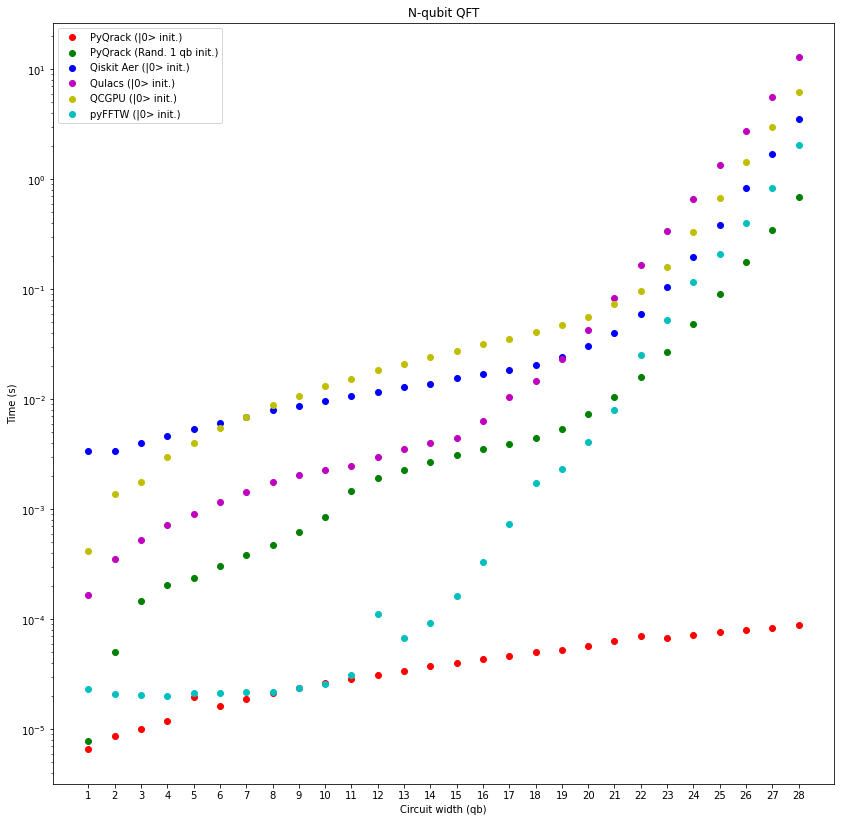

In [11]:
import matplotlib.pyplot as plt

fig = plt.gcf()
fig.set_size_inches(14, 14)

colors = list("cymbgr")

x = qrack_0_results.keys()
y = qrack_0_results.values()
plt.scatter(x,y,color=colors.pop())

x = qrack_results.keys()
y = qrack_results.values()
plt.scatter(x,y,color=colors.pop())

x = aer_results.keys()
y = aer_results.values()
plt.scatter(x,y,color=colors.pop())

x = qulacs_results.keys()
y = qulacs_results.values()
plt.scatter(x,y,color=colors.pop())

x = qcgpu_results.keys()
y = qcgpu_results.values()
plt.scatter(x,y,color=colors.pop())

x = fftw_results.keys()
y = fftw_results.values()
plt.scatter(x,y,color=colors.pop())

plt.title("N-qubit QFT")
plt.xlabel("Circuit width (qb)")
plt.ylabel("Time (s)")
plt.legend(["PyQrack (|0> init.)", "PyQrack (Rand. 1 qb init.)", "Qiskit Aer (|0> init.)", "Qulacs (|0> init.)", "QCGPU (|0> init.)", "pyFFTW (|0> init.)"])
plt.yscale("log")
plt.xticks(np.arange(low, high + 1, step=1))

plt.show()

fig.savefig('qft_chart.png', dpi=100)

In [12]:
import platform

print(platform.machine())
print(platform.version())
print(platform.platform())
print(platform.uname())
print(platform.system())
print(platform.processor())

x86_64
#33~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Mon Jan 30 17:03:34 UTC 2
Linux-5.19.0-32-generic-x86_64-with-glibc2.35
uname_result(system='Linux', node='sekhmet', release='5.19.0-32-generic', version='#33~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Mon Jan 30 17:03:34 UTC 2', machine='x86_64')
Linux
x86_64


In [13]:
import subprocess

line_as_bytes = subprocess.check_output("nvidia-smi -L", shell=True)
line = line_as_bytes.decode("ascii")
_, line = line.split(":", 1)
line, _ = line.split("(")
print(line.strip())

NVIDIA GeForce RTX 3080 Laptop GPU


In [14]:
import cpuinfo
cpuinfo.get_cpu_info()['brand_raw']

'Intel(R) Core(TM) i9-10980HK CPU @ 2.40GHz'